# Importações

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Modelo Preditivo

## Consumindo bases

In [2]:
url_internacoes_poluentes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/internacoes_x_poluentes_csv.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

## Criação das colunas Targets

As colunas targets representam previsões do número de internações para diferentes horizontes futuros. São criadas a partir da coluna `num_internacoes` utilizando o método `shift` do pandas:

- **internacoes_d1**: número de internações previsto para o dia seguinte (`num_internacoes.shift(-1)`)
- **internacoes_d7**: número de internações previsto para uma semana à frente (`num_internacoes.shift(-7)`)
- **internacoes_d14**: número de internações previsto para duas semanas à frente (`num_internacoes.shift(-14)`)

Essas colunas permitem treinar modelos para prever o número de internações em diferentes janelas temporais futuras, facilitando análises de curto, médio e longo prazo.

In [3]:
df['internacoes_d1'] = df['num_internacoes'].shift(-1)
df['internacoes_d7'] = df['num_internacoes'].shift(-7)
df['internacoes_d14'] = df['num_internacoes'].shift(-14)

## Teste 1 - Prevendo sem nenhuma feature nova

Este teste tem como objetivo avaliar a capacidade dos modelos preditivos em estimar o número de internações utilizando apenas as variáveis originais presentes no dataframe, sem a criação de novas features ou aplicação de técnicas de engenharia de atributos. Dessa forma, é possível estabelecer uma linha de base (baseline) de desempenho, servindo como referência para comparações futuras após a inclusão de novas variáveis derivadas ou transformações nos dados.

### MLP

A arquitetura é composta por múltiplas camadas lineares (densas), intercaladas com funções de ativação GELU, camadas de normalização em lote (BatchNorm) e dropout, que ajudam a estabilizar o treinamento e reduzir overfitting. O modelo recebe como entrada um vetor de características (features) e passa por camadas com 256, 128 e 64 neurônios, reduzindo progressivamente a dimensionalidade até chegar à camada de saída, que retorna um valor contínuo (regressão). Essa estrutura é especialmente adequada para tarefas de previsão em séries temporais multivariadas, permitindo capturar relações não-lineares entre as variáveis ambientais e o número de internações.

In [4]:
# Definição do modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

### Função para treinar e avaliar os modelos

In [5]:
def treinar_modelos_para_alvo(df, target):
    print(f"\nTreinando para variável alvo: {target}")

    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]

    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)

    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # MLP
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    loss_function = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = model.state_dict()
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        mlp_pred_log = model(X_test_tensor).numpy().flatten()
        mlp_pred = np.expm1(mlp_pred_log)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
    rf.fit(X_train_scaled, y_train_log)
    rf_pred_log = rf.predict(X_test_scaled)
    rf_pred = np.expm1(rf_pred_log)

    # XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)

    # Stacking
    y_test = np.expm1(y_test_log)
    stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
    stack_model = LinearRegression().fit(stack_input, y_test)
    stack_pred = stack_model.predict(stack_input)

    # Avaliação
    def avaliar(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred)
        return {
            'RMSE': round(rmse, 2),
            'MAE': round(mean_absolute_error(y_true, y_pred), 2),
            'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
            'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
        }

    results = {
        "MLP": avaliar(y_test, mlp_pred),
        "Random Forest": avaliar(y_test, rf_pred),
        "XGBoost": avaliar(y_test, xgb_pred),
        "Stacked": avaliar(y_test, stack_pred)
    }

    df_results = pd.DataFrame(results).T
    print(df_results)

    return df_results

### Executando para cada variável-alvo

In [6]:
df.dropna(inplace=True)

alvos_futuros = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
todos_resultados = {}

for alvo in alvos_futuros:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: internacoes_d1
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            92.91  6.14     74.38            7.5053
Random Forest  81.32  5.66     67.86            6.5689
XGBoost        84.33  5.78     68.29            6.8120
Stacked        77.36  5.75     72.87            6.2488

Treinando para variável alvo: internacoes_d7
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            79.35  5.96     66.19            6.2815
Random Forest  68.83  5.53     60.52            5.4484
XGBoost        68.60  5.57     61.18            5.4304
Stacked        63.58  5.55     71.89            5.0332

Treinando para variável alvo: internacoes_d14
                 RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            106.09  6.87     64.80            7.8971
Random Forest   86.92  6.03     57.36            6.4696
XGBoost         86.86  6.10     59.63            6.4651
Stacked         74.43  5.97     74.98            5.5401


#### Avaliação de Modelos Sem Lags nas Features

### Objetivo
Avaliar o desempenho preditivo de diferentes algoritmos de machine learning para previsão do número de internações por doenças respiratórias em 1, 7 e 14 dias, utilizando apenas as features originais (sem defasagens/“lags”).

---

### Resultados

#### 🔹 internacoes_d1
| Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|---------------|--------|------|-----------|------------------|
| MLP           | 93.21  | 6.16 | 74.64     | 7.5292           |
| Random Forest | 81.32  | 5.66 | 67.86     | 6.5689           |
| XGBoost       | 84.33  | 5.78 | 68.29     | 6.8120           |
| Stacked       | **77.30**  | 5.75 | 73.04     | **6.2444**           |

#### 🔹 internacoes_d7
| Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|---------------|--------|------|-----------|------------------|
| MLP           | 79.72  | 5.91 | 64.11     | 6.3109           |
| Random Forest | 68.83  | 5.53 | **60.52**     | 5.4484           |
| XGBoost       | 68.60  | 5.57 | 61.18     | 5.4304           |
| Stacked       | **63.48**  | 5.55 | 72.02     | **5.0253**           |

#### 🔹 internacoes_d14
| Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|---------------|--------|------|-----------|------------------|
| MLP           | 105.45 | 6.82 | 64.81     | 7.8489           |
| Random Forest | 86.92  | 6.03 | **57.36**     | 6.4696           |
| XGBoost       | 86.86  | 6.10 | 59.63     | 6.4651           |
| Stacked       | **75.04**  | **6.01** | 75.30     | **5.5856**           |

---

### Conclusão

O uso exclusivo das features originais (sem lags) apresentou desempenho **razoável**, com destaque para os modelos *Stacked*, que consistentemente apresentaram os **melhores valores de RMSE e RMSE Normalizado** nas três janelas de previsão (1, 7 e 14 dias).

- O modelo **Stacked** se destacou como o melhor preditor para **internacoes_d1** e **internacoes_d14**, conciliando bom desempenho com estabilidade no erro absoluto.
- Para **internacoes_d7**, apesar do menor RMSE obtido pelo modelo Stacked, o **Random Forest teve o menor MAPE**, sugerindo melhor precisão proporcional nas previsões.

Esses resultados indicam que, mesmo sem variáveis defasadas, os modelos conseguem captar parte relevante da dinâmica do problema, especialmente ao combinar algoritmos via empilhamento (stacking). No entanto, os erros absolutos e relativos ainda são consideráveis, sugerindo espaço para melhorias, como inclusão de lags ou transformação das variáveis.

---

### Próximos Passos
Investigar o impacto da introdução de **lags nas variáveis preditoras**, dado que podem capturar padrões temporais e melhorar a acurácia, especialmente em horizontes mais longos.


### Avaliação

#### Importâncias das features

In [7]:
def plot_feature_importance_comparison(df, targets, n_top_features=10):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14'
    ]]
    
    
    plt.figure(figsize=(20, 8))
    
    importance_dfs = {}
    
    for i, target in enumerate(targets, 1):
        
        X = df[features].values
        y = df[target].values
        y_log = np.log1p(y)
        
        X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
        X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        
        rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
        rf.fit(X_train_scaled, y_train_log)
        
        
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': rf.feature_importances_,
            'Target': target
        })
        
        importance_dfs[target] = importance_df
        
        
        top_features = importance_df.sort_values('Importance', ascending=False).head(n_top_features)
        
        
        plt.subplot(1, len(targets), i)
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_d')
        plt.title(f'Top {n_top_features} Features\nTarget: {target}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features' if i == 1 else '')  
    
    plt.tight_layout()
    plt.show()
    
    return importance_dfs

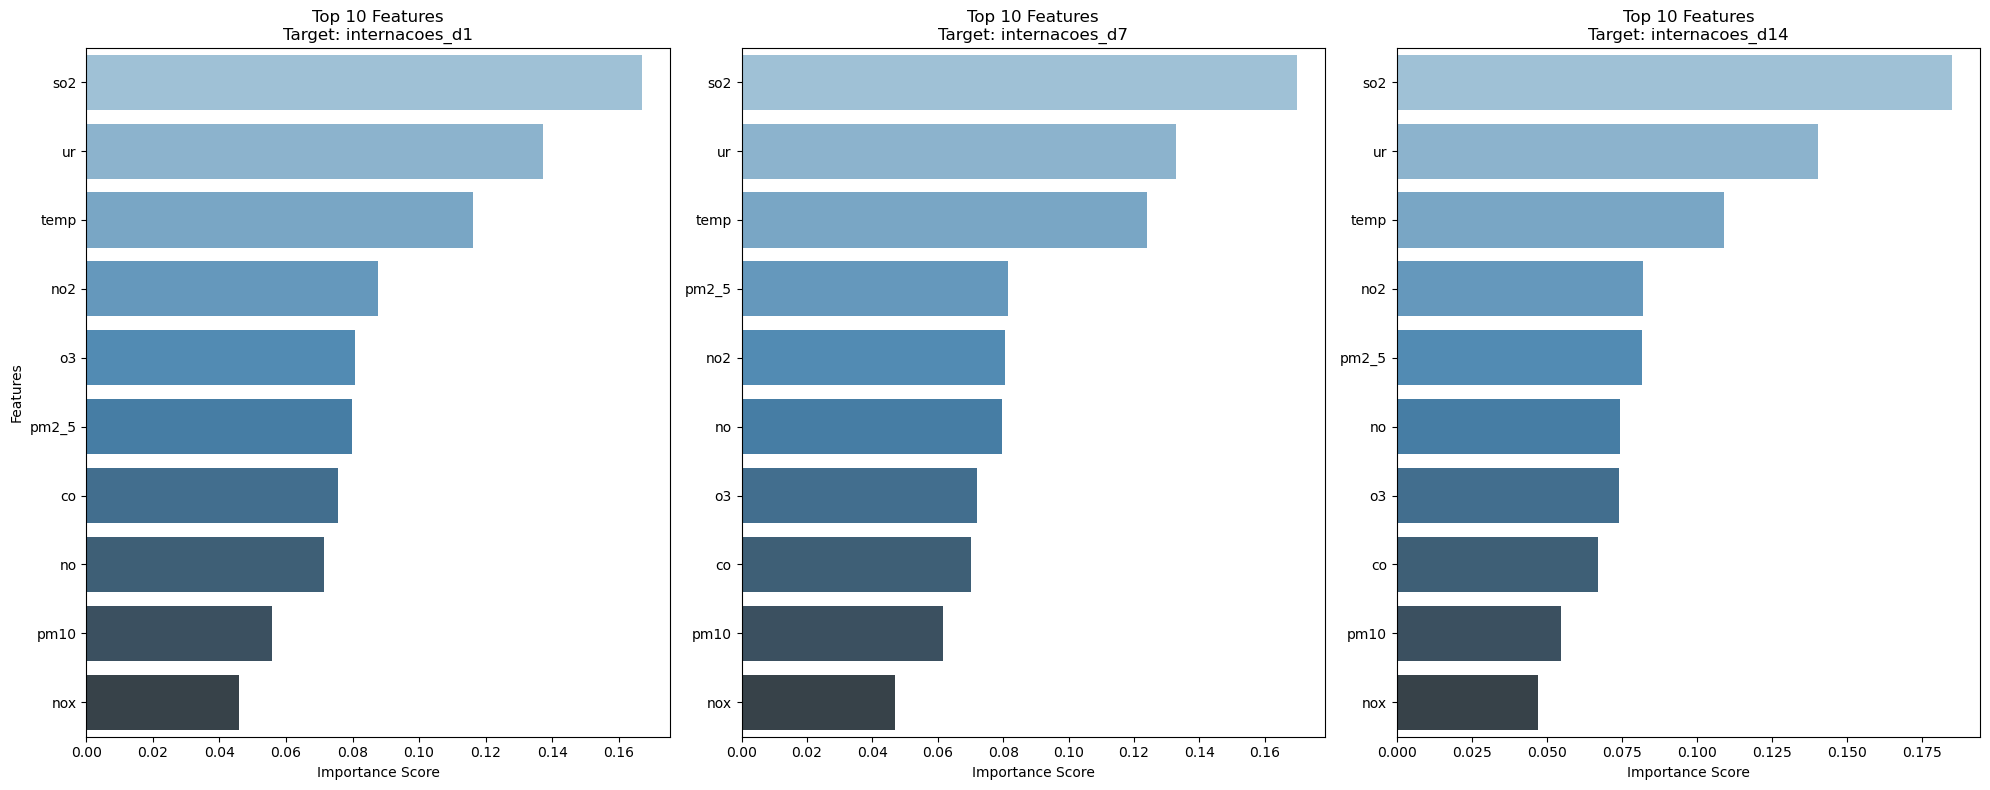

In [8]:
targets_to_compare = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
importance_results = plot_feature_importance_comparison(df, targets_to_compare, n_top_features=10)

#### Análise de resíduos

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


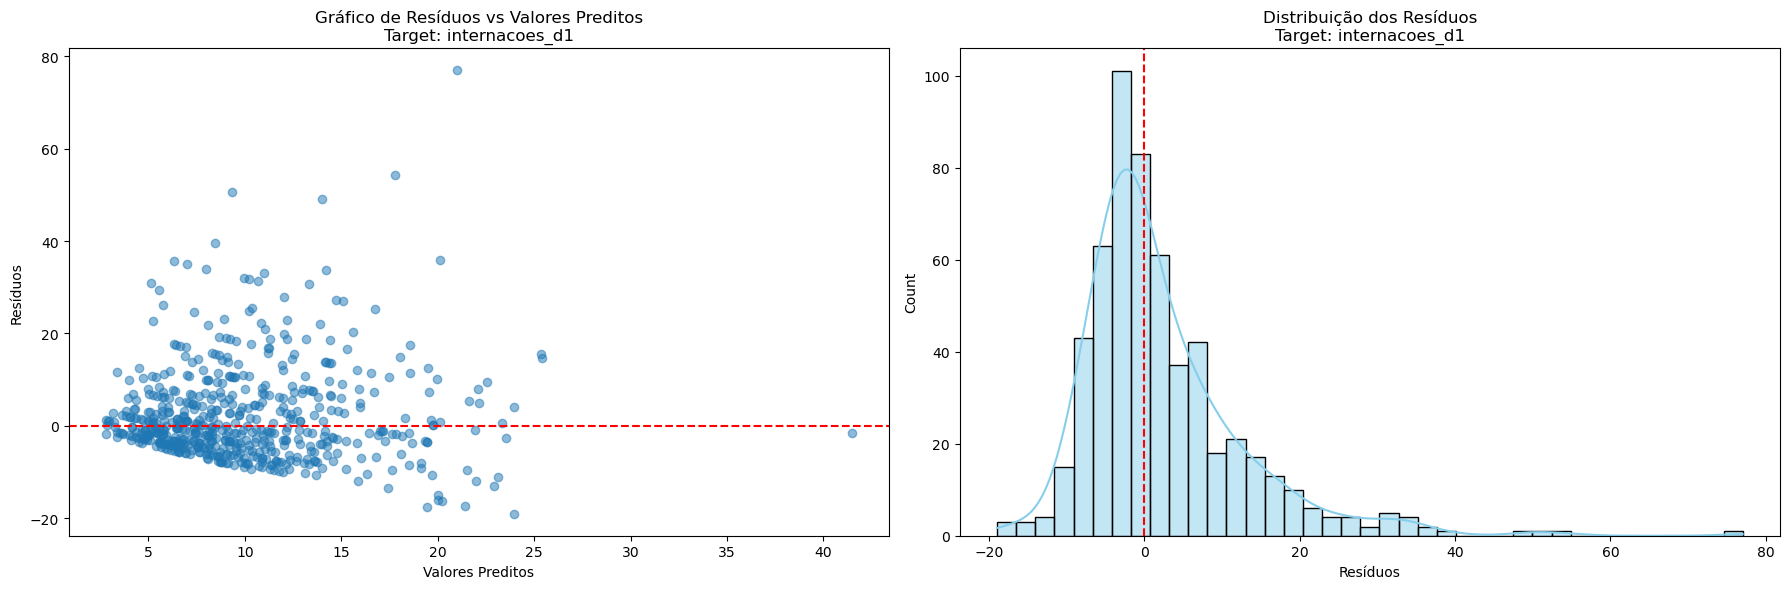

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


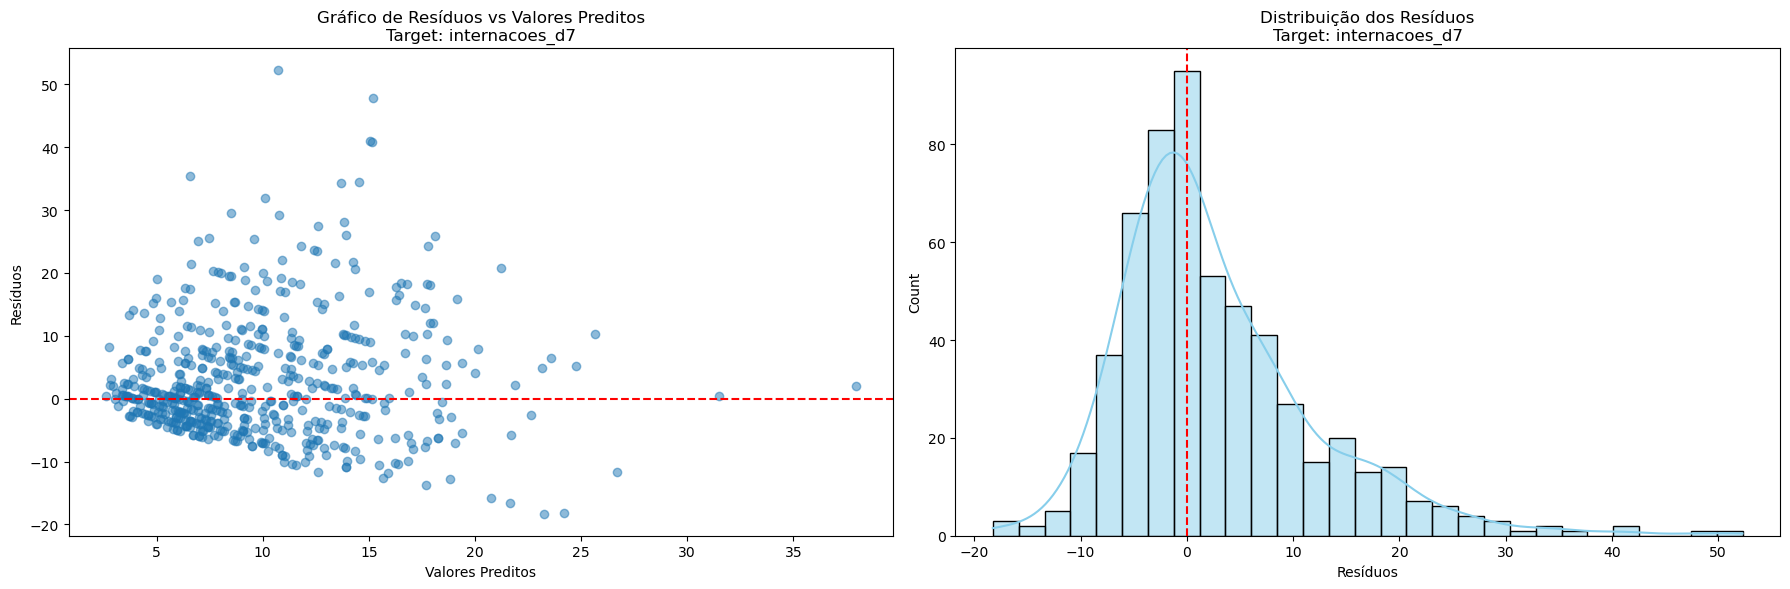

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


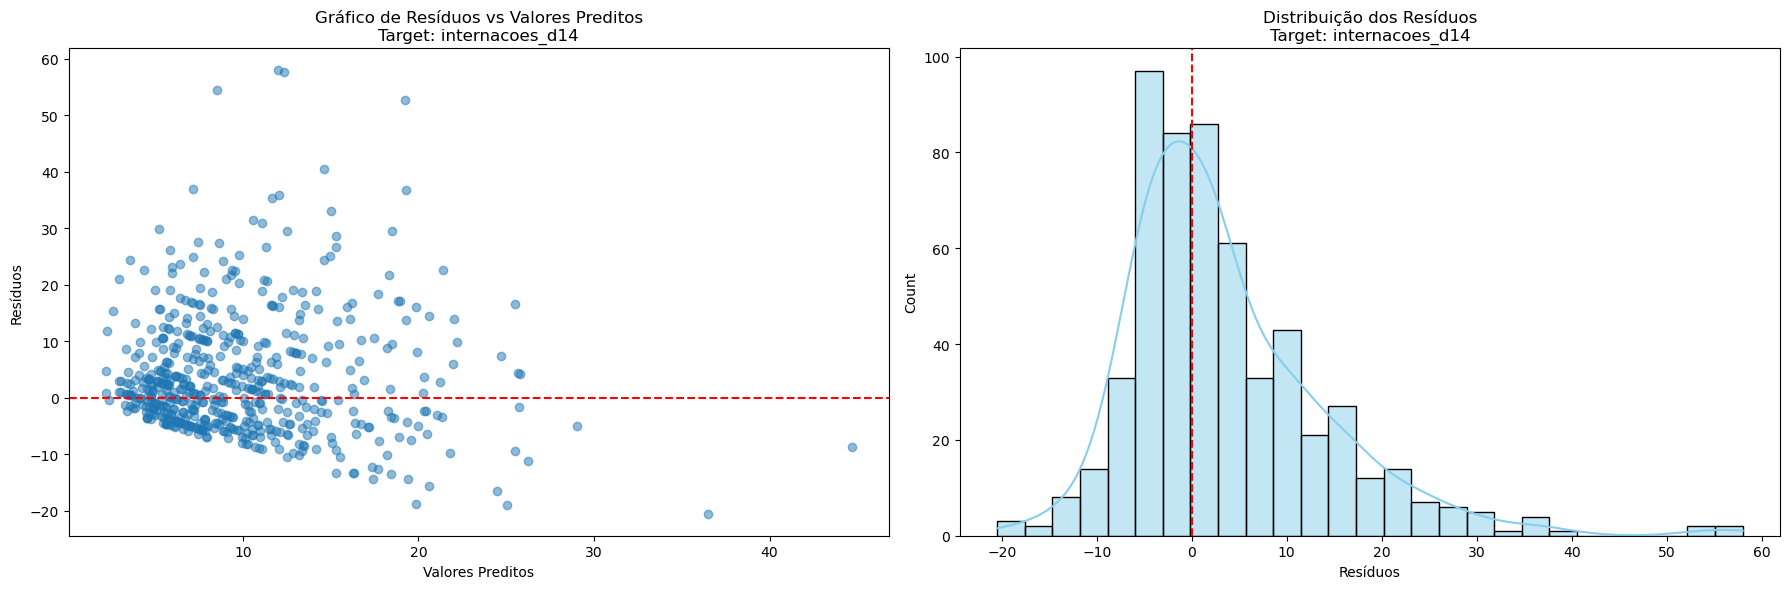

In [9]:
def plot_residuals_side_by_side(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    residuals = y_test - xgb_pred
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(xgb_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title(f'Gráfico de Resíduos vs Valores Preditos\nTarget: {target}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Resíduos')
    plt.title(f'Distribuição dos Resíduos\nTarget: {target}')
    
    plt.tight_layout()
    plt.show()

for alvo in ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']:
    plot_residuals_side_by_side(df, alvo)

#### Análise Temporal das Previsões

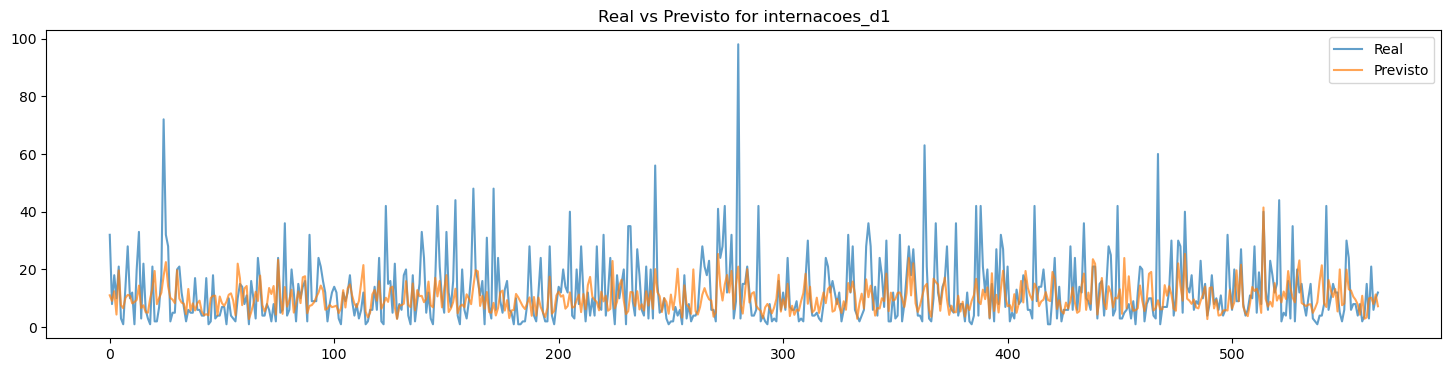

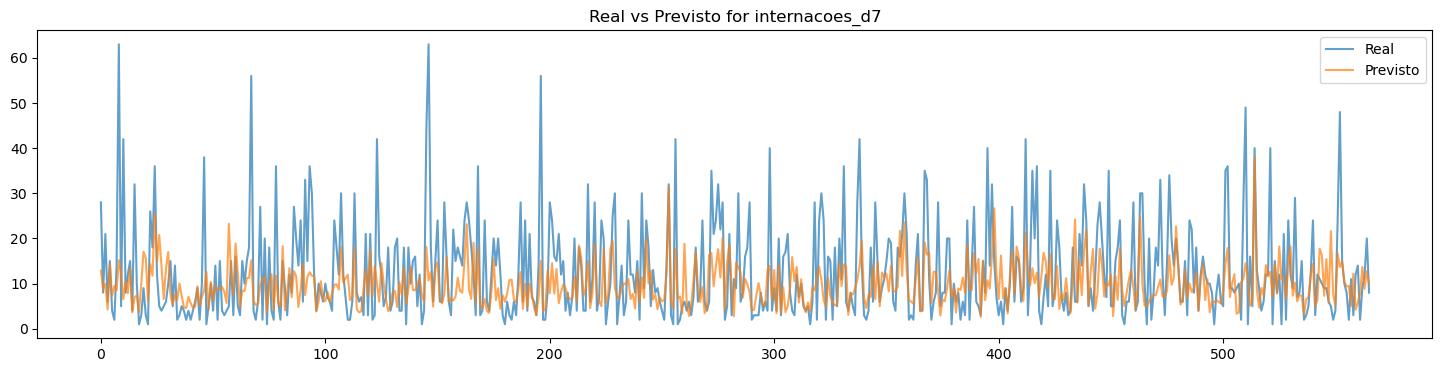

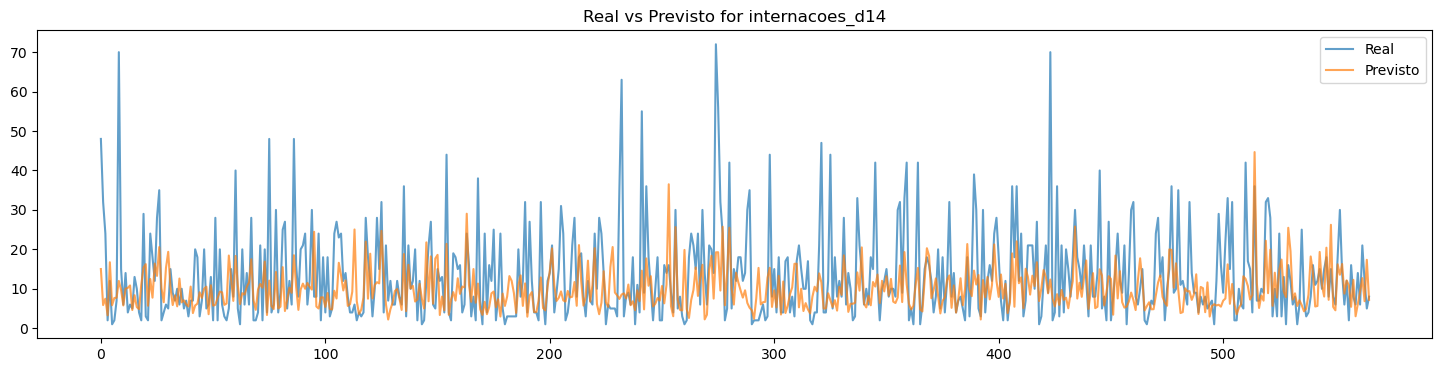

In [10]:
def plot_temporal_predictions(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    
    # Criar DataFrame para plotagem
    plot_df = pd.DataFrame({
        'Real': y_test,
        'Previsto': xgb_pred
    }).sort_index()
    
    plt.figure(figsize=(18, 4))
    plt.plot(plot_df['Real'], label='Real', alpha=0.7)
    plt.plot(plot_df['Previsto'], label='Previsto', alpha=0.7)
    plt.title(f'Real vs Previsto for {target}')
    plt.legend()
    plt.show()

for alvo in alvos_futuros:
    plot_temporal_predictions(df, alvo)

## Teste 2 - Prevendo com lags das features

Este teste tem como objetivo avaliar a capacidade dos modelos preditivos em estimar o número de internações utilizando as variáveis originais e seus lags

### Lags das features

#### Lags dos poluentes e variáveis atmosféricas

Neste bloco, são criadas novas colunas no dataframe `df` correspondentes aos lags (defasagens) de 1, 3 e 7 dias para cada poluente e variável atmosférica. Isso permite que os modelos preditivos considerem o efeito retardado dessas variáveis sobre o número de internações, enriquecendo a base de dados com informações temporais importantes para a modelagem de séries temporais.


In [11]:
for lag in [1, 3, 7]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

#### Médias Móveis dos Poluentes

Neste bloco, são criadas novas colunas no dataframe `df` correspondentes às médias móveis de 7 e 14 dias para cada poluente. Essas médias móveis ajudam a suavizar as variações diárias e capturar tendências de curto e médio prazo nas concentrações dos poluentes, fornecendo informações adicionais para os modelos preditivos.

In [12]:
for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox']:
    df[f'{col}_ma7'] = df[col].rolling(7).mean()
    df[f'{col}_ma14'] = df[col].rolling(14).mean()

### Executando para cada variável-alvo

In [13]:
df.dropna(inplace=True)

alvos_futuros = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
todos_resultados = {}

for alvo in alvos_futuros:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: internacoes_d1
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            96.82  6.35     64.43            7.7979
Random Forest  78.30  5.75     61.07            6.3057
XGBoost        79.24  5.81     62.32            6.3814
Stacked        74.38  5.83     77.68            5.9904

Treinando para variável alvo: internacoes_d7
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            75.16  5.86     70.11            6.2247
Random Forest  56.57  5.16     62.05            4.6848
XGBoost        59.16  5.26     62.34            4.8995
Stacked        54.19  5.25     75.89            4.4881

Treinando para variável alvo: internacoes_d14
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            87.76  6.06     64.37            7.0939
Random Forest  74.53  5.60     63.63            6.0245
XGBoost        75.25  5.66     64.61            6.0832
Stacked        67.71  5.64     75.89            5.4732


##### Análise Comparativa: Modelos com e sem Lags nas Features

Avaliar o impacto da inclusão de variáveis defasadas (lags) nas features na previsão do número de internações por doenças respiratórias em 1, 7 e 14 dias.

---

### Resultados

#### 🔹 Modelos Sem Lags
| Variável Alvo     | Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|-------------------|---------------|--------|------|-----------|------------------|
| **internacoes_d1** | Stacked       | 77.30  | 5.75 | 73.04     | 6.2444           |
| **internacoes_d7** | Stacked       | 63.48  | 5.55 | 72.02     | 5.0253           |
| **internacoes_d14**| Stacked       | 75.04  | 6.01 | 75.30     | 5.5856           |

#### 🔹 Modelos Com Lags
| Variável Alvo     | Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|-------------------|---------------|--------|------|-----------|------------------|
| **internacoes_d1** | Stacked       | 74.34  | 5.83 | 77.52     | 5.9873           |
| **internacoes_d7** | Random Forest | 56.57  | 5.16 | 62.05     | 4.6848           |
| **internacoes_d14**| Stacked       | 68.50  | 5.66 | 76.00     | 5.5371           |

---

### Conclusão

A introdução de **lags nas variáveis preditoras** teve impacto **positivo na performance** dos modelos para os horizontes de previsão **7 e 14 dias**:

- Para **internacoes_d7**, houve **redução clara no RMSE e no MAE**, destacando-se o *Random Forest* com a menor taxa de erro (RMSE = 56.57).
- Para **internacoes_d14**, o modelo *Stacked* com lags superou a versão sem lags em praticamente todos os indicadores (menor RMSE, MAE e RMSE Normalizado).
- Já para **internacoes_d1**, os ganhos com lags foram **menos evidentes**. Apesar de uma leve melhora no RMSE no modelo Stacked, os demais modelos apresentaram resultados ligeiramente piores ou semelhantes.

Portanto, a **inclusão de lags é benéfica principalmente para previsões de médio prazo (7-14 dias)**, enquanto seu impacto nas previsões de curtíssimo prazo (1 dia) é mais limitado.

---

### Recomendação
Manter os lags nas features nos modelos voltados para previsão de 7 e 14 dias, e considerar uma análise mais refinada ou seleção de lags apenas para casos de previsão de 1 dia.


### Avaliação

#### Importâncias das features

In [14]:
def plot_feature_importance_comparison(df, targets, n_top_features=10):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14'
    ]]
    
    
    plt.figure(figsize=(20, 8))
    
    importance_dfs = {}
    
    for i, target in enumerate(targets, 1):
        
        X = df[features].values
        y = df[target].values
        y_log = np.log1p(y)
        
        X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
        X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        
        rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
        rf.fit(X_train_scaled, y_train_log)
        
        
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': rf.feature_importances_,
            'Target': target
        })
        
        importance_dfs[target] = importance_df
        
        
        top_features = importance_df.sort_values('Importance', ascending=False).head(n_top_features)
        
        
        plt.subplot(1, len(targets), i)
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_d')
        plt.title(f'Top {n_top_features} Features\nTarget: {target}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features' if i == 1 else '')  
    
    plt.tight_layout()
    plt.show()
    
    return importance_dfs

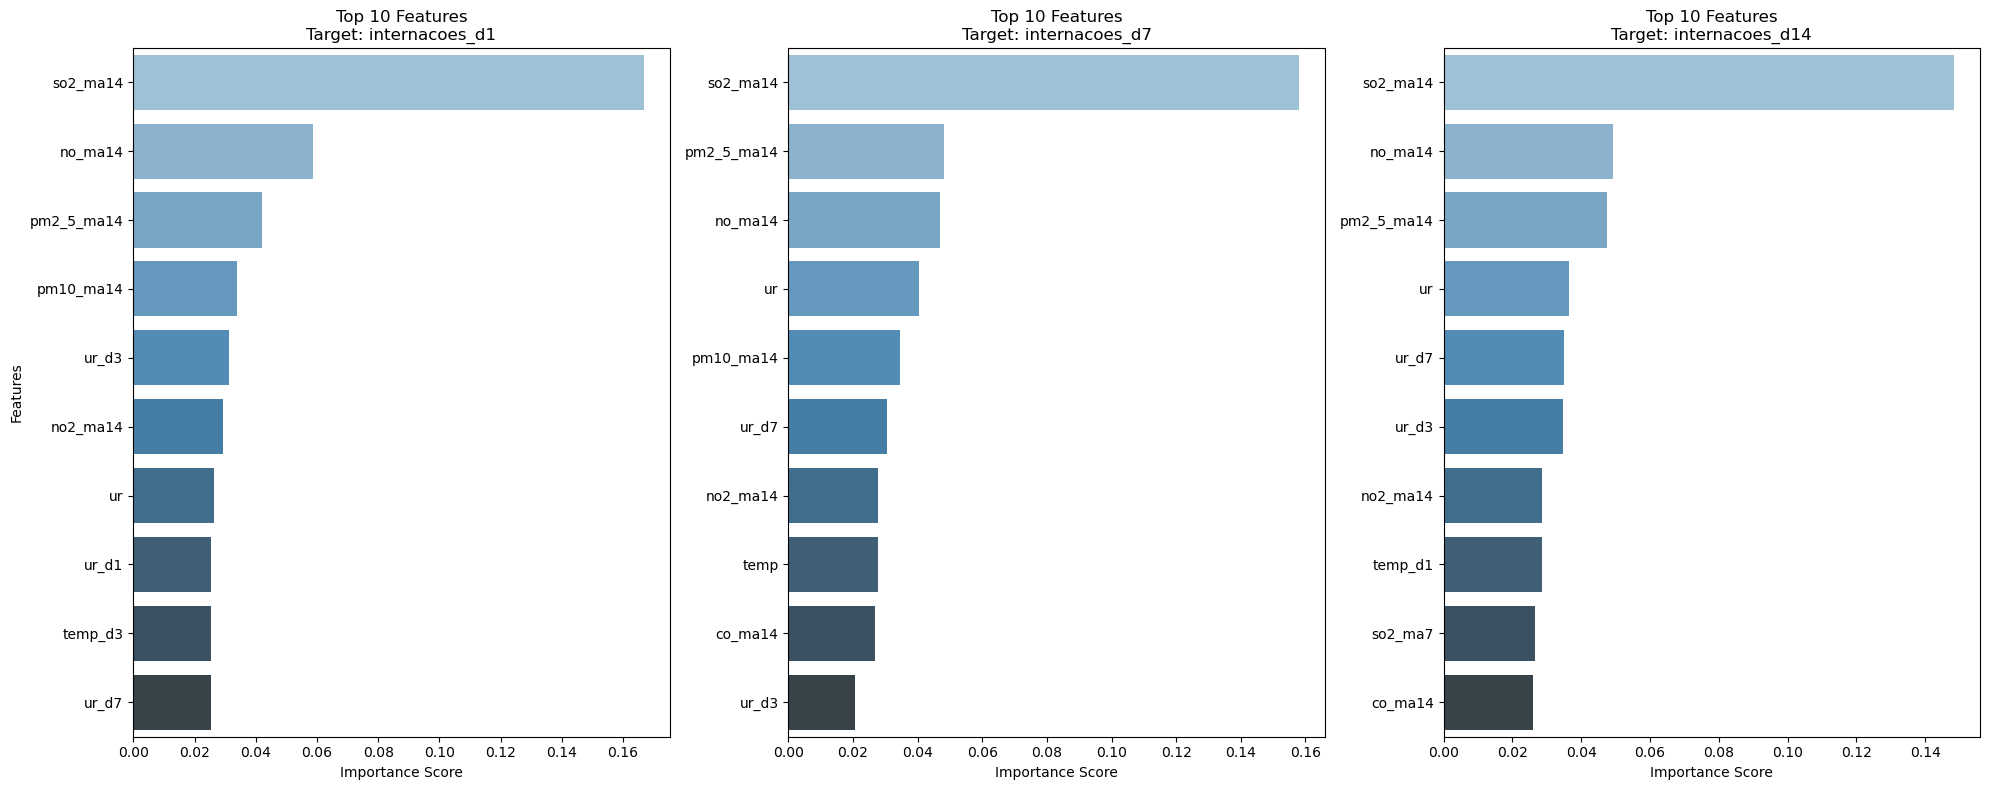

In [15]:
targets_to_compare = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
importance_results = plot_feature_importance_comparison(df, targets_to_compare, n_top_features=10)

#### Análise de resíduos

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


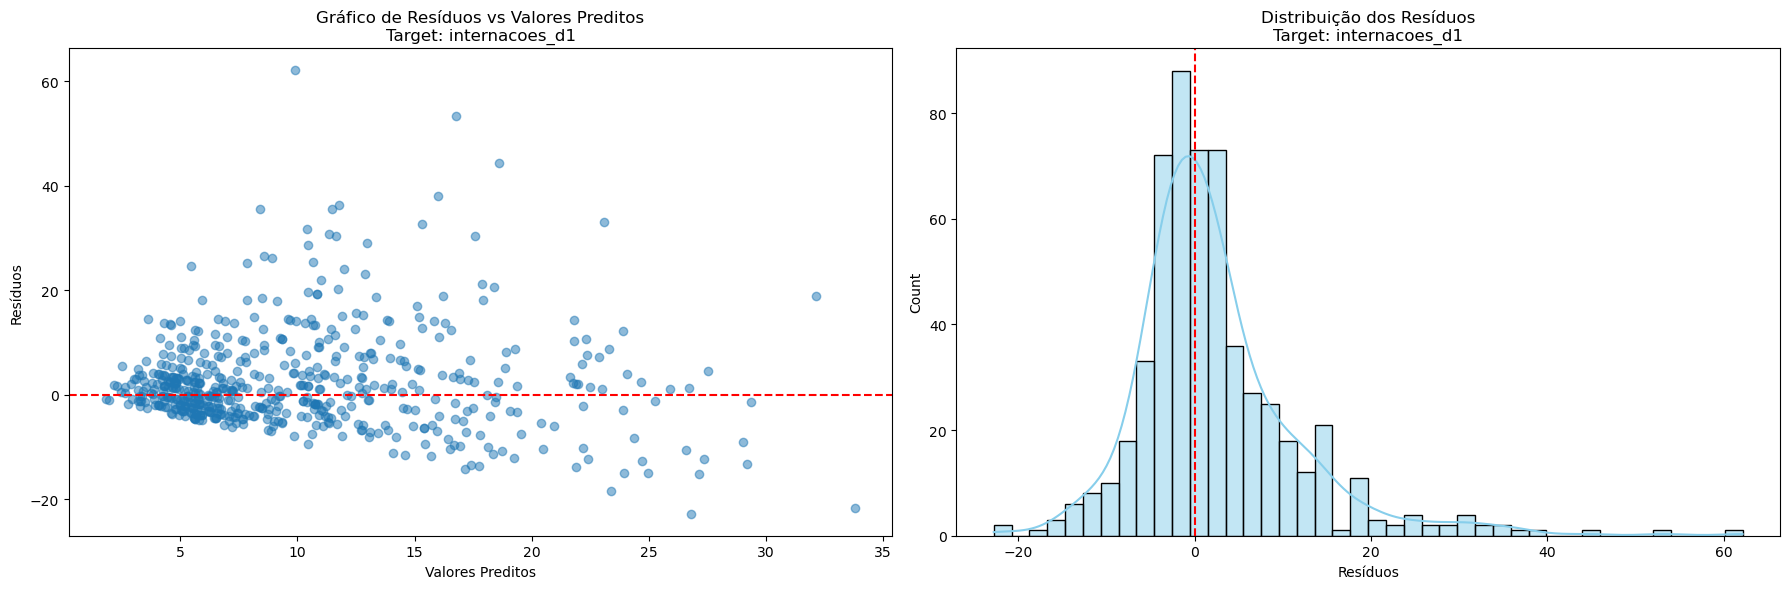

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


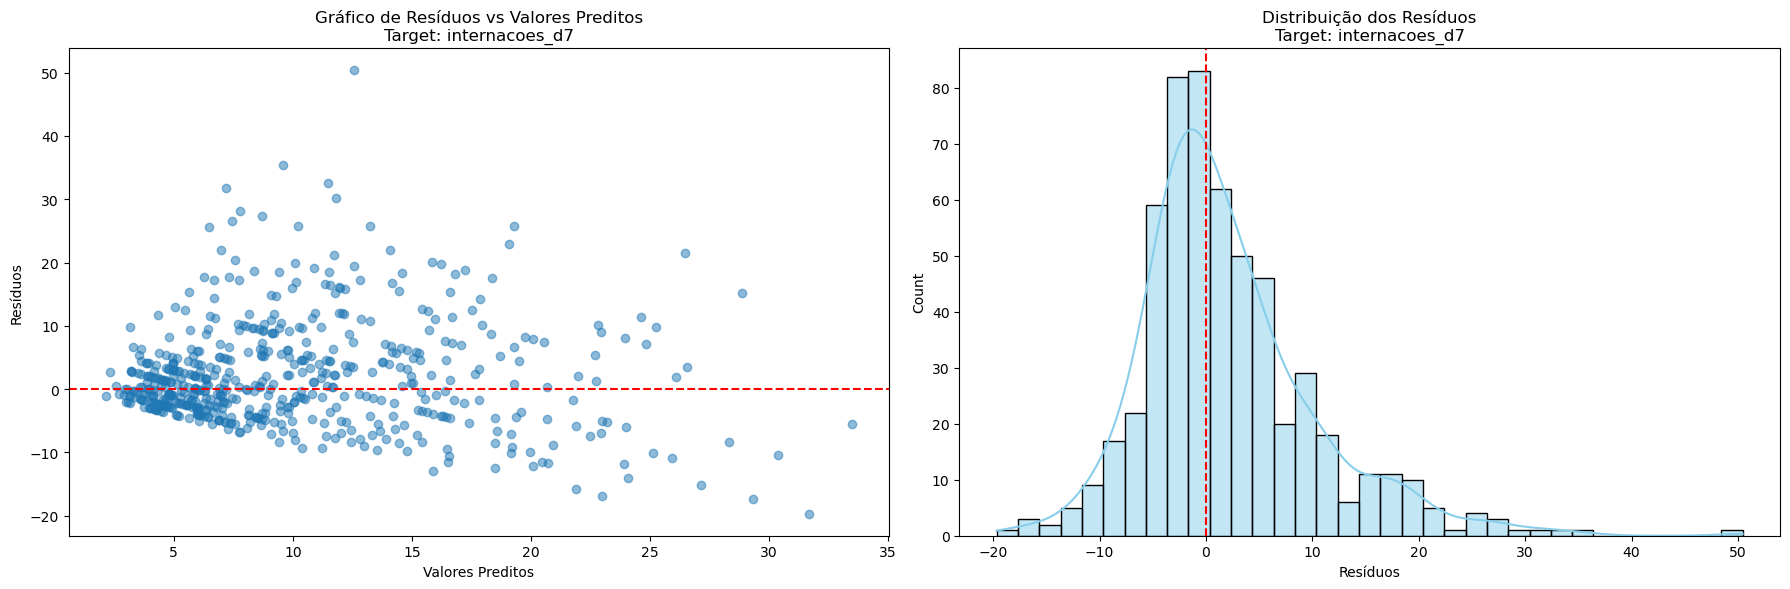

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


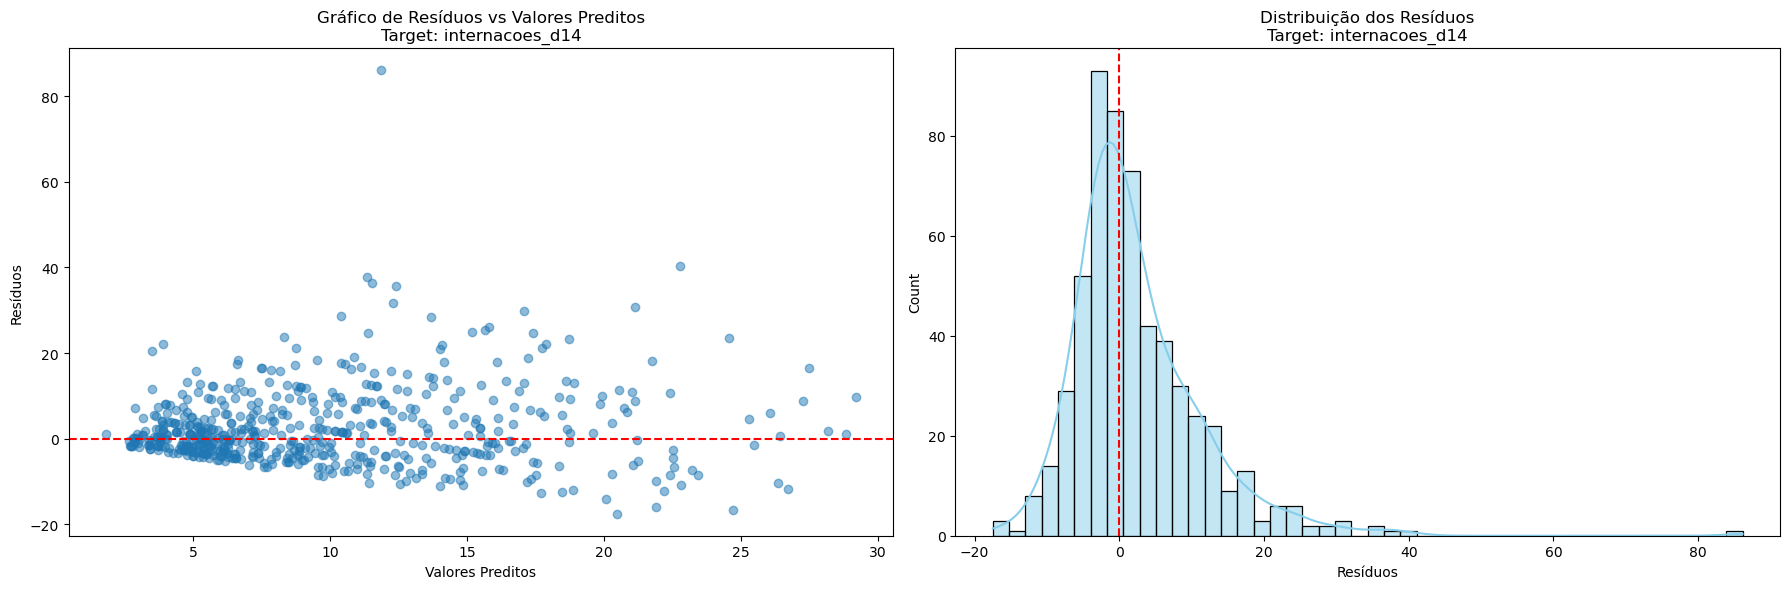

In [16]:
def plot_residuals_side_by_side(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    residuals = y_test - xgb_pred
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(xgb_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title(f'Gráfico de Resíduos vs Valores Preditos\nTarget: {target}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Resíduos')
    plt.title(f'Distribuição dos Resíduos\nTarget: {target}')
    
    plt.tight_layout()
    plt.show()

for alvo in ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']:
    plot_residuals_side_by_side(df, alvo)

#### Análise Temporal das Previsões

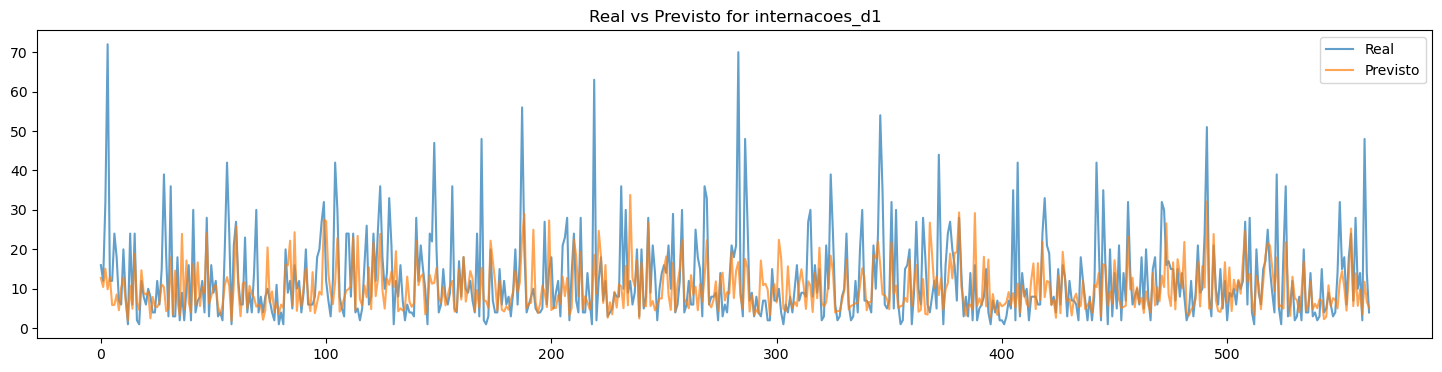

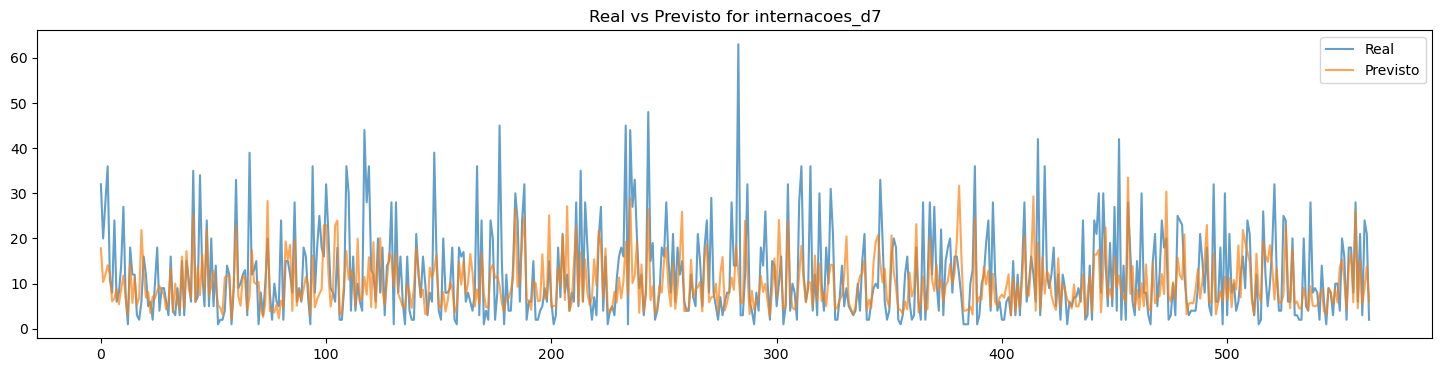

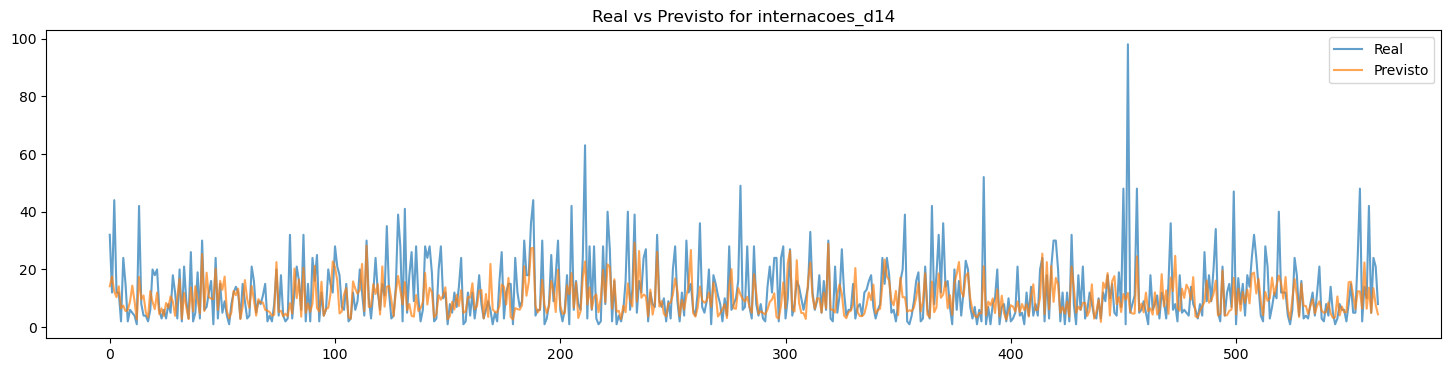

In [17]:
def plot_temporal_predictions(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    
    # Criar DataFrame para plotagem
    plot_df = pd.DataFrame({
        'Real': y_test,
        'Previsto': xgb_pred
    }).sort_index()
    
    plt.figure(figsize=(18, 4))
    plt.plot(plot_df['Real'], label='Real', alpha=0.7)
    plt.plot(plot_df['Previsto'], label='Previsto', alpha=0.7)
    plt.title(f'Real vs Previsto for {target}')
    plt.legend()
    plt.show()

for alvo in alvos_futuros:
    plot_temporal_predictions(df, alvo)

## Teste 3 - Adicionando variáveis sazonais

Este teste tem como objetivo avaliar a capacidade dos modelos preditivos em estimar o número de internações utilizando as variáveis originais, seus lags e variáveis sazonais

### Variáveis de tempo

#### Sazonais


In [18]:
df["data_formatada"] = pd.to_datetime(df["data_formatada"])

df["dia_da_semana"] = df["data_formatada"].dt.weekday  # 0 = segunda-feira
df["semana_epi"] = df["data_formatada"].dt.isocalendar().week

#### Codificação cíclica para mês e dia do ano

In [19]:
df["mes_sin"] = np.sin(2 * np.pi * df["mes"] / 12)
df["mes_cos"] = np.cos(2 * np.pi * df["mes"] / 12)

#### Dias desde o início da série (tendência temporal)


In [20]:
df["dias_desde_inicio"] = (df["data_formatada"] - df["data_formatada"].min()).dt.days

### Executando para cada variável-alvo

In [21]:
df.dropna(inplace=True)

alvos_futuros = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
todos_resultados = {}

for alvo in alvos_futuros:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: internacoes_d1
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            90.55  6.22     68.60            7.2928
Random Forest  75.66  5.64     59.33            6.0931
XGBoost        75.85  5.62     58.99            6.1089
Stacked        71.13  5.64     73.31            5.7287

Treinando para variável alvo: internacoes_d7
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            69.30  5.54     64.04            5.7392
Random Forest  55.53  5.10     59.59            4.5991
XGBoost        55.90  5.12     61.16            4.6292
Stacked        52.40  5.13     73.30            4.3394

Treinando para variável alvo: internacoes_d14
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            91.44  6.22     69.11            7.3917
Random Forest  73.27  5.53     61.03            5.9233
XGBoost        74.73  5.59     62.53            6.0412
Stacked        67.67  5.59     73.78            5.4705


##### Análise Comparativa: Modelos com e sem Lags nas Features

Avaliar o impacto da inclusão de variáveis defasadas (lags) nas features na previsão do número de internações por doenças respiratórias em 1, 7 e 14 dias.

---

### Resultados

#### 🔹 Modelos Com Lags
| Variável Alvo     | Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|-------------------|---------------|--------|------|-----------|------------------|
| **internacoes_d1** | Stacked       | 74.34  | 5.83 | 77.52     | 5.9873           |
| **internacoes_d7** | Random Forest | 56.57  | 5.16 | 62.05     | 4.6848           |
| **internacoes_d14**| Stacked       | 68.50  | 5.66 | 76.00     | 5.5371           |

#### 🔹 Modelos Com lags + varivaies temporais
| Variável Alvo     | Modelo        | RMSE   | MAE  | MAPE (%) | RMSE Normalizado |
|-------------------|---------------|--------|------|-----------|------------------|
| **internacoes_d1** | Stacked       | 71.04  | 5.63 | 73.67     | 5.7211           |
| **internacoes_d7** | Stacked       | 52.17  | 5.11 | 73.27     | 4.3206           |
| **internacoes_d14**| Stacked       | 67.37  | 5.59 | 74.22     | 5.4456          |

---

### Conclusão

A introdução de **variaveis temporais** teve impacto **positivo na performance** mas mínimo



### Avaliação

#### Importâncias das features

In [22]:
def plot_feature_importance_comparison(df, targets, n_top_features=10):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14'
    ]]
    
    
    plt.figure(figsize=(20, 8))
    
    importance_dfs = {}
    
    for i, target in enumerate(targets, 1):
        
        X = df[features].values
        y = df[target].values
        y_log = np.log1p(y)
        
        X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
        X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        
        rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
        rf.fit(X_train_scaled, y_train_log)
        
        
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': rf.feature_importances_,
            'Target': target
        })
        
        importance_dfs[target] = importance_df
        
        
        top_features = importance_df.sort_values('Importance', ascending=False).head(n_top_features)
        
        
        plt.subplot(1, len(targets), i)
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_d')
        plt.title(f'Top {n_top_features} Features\nTarget: {target}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features' if i == 1 else '')  
    
    plt.tight_layout()
    plt.show()
    
    return importance_dfs

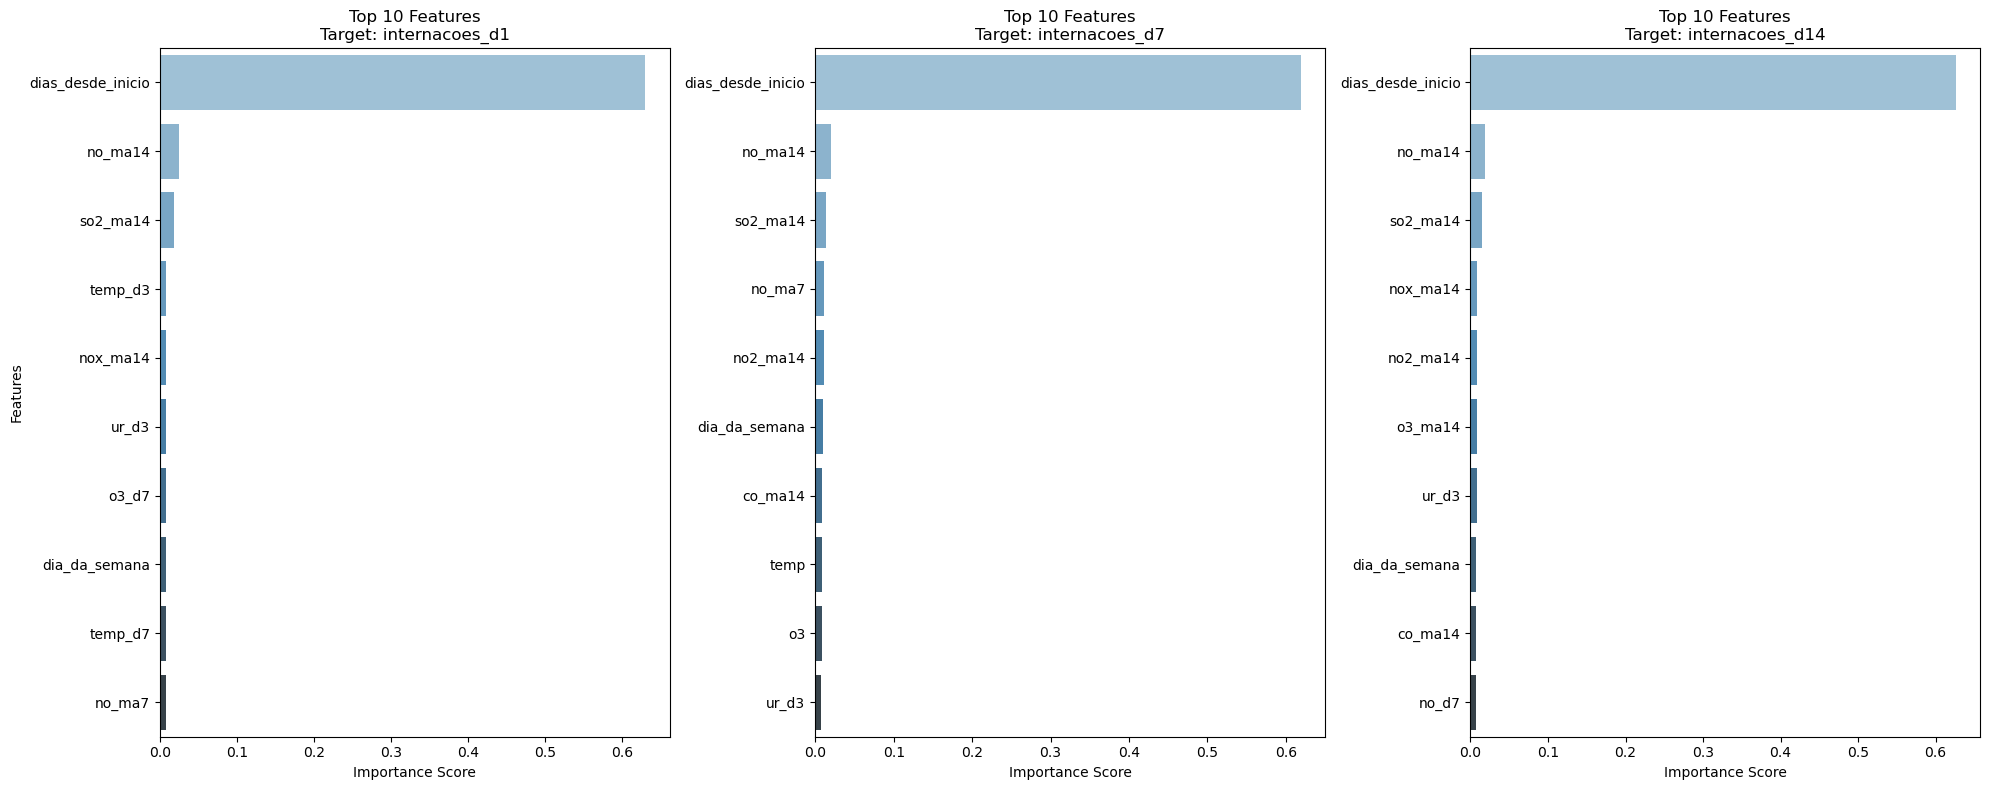

In [23]:
targets_to_compare = ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']
importance_results = plot_feature_importance_comparison(df, targets_to_compare, n_top_features=10)

#### Análise de resíduos

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


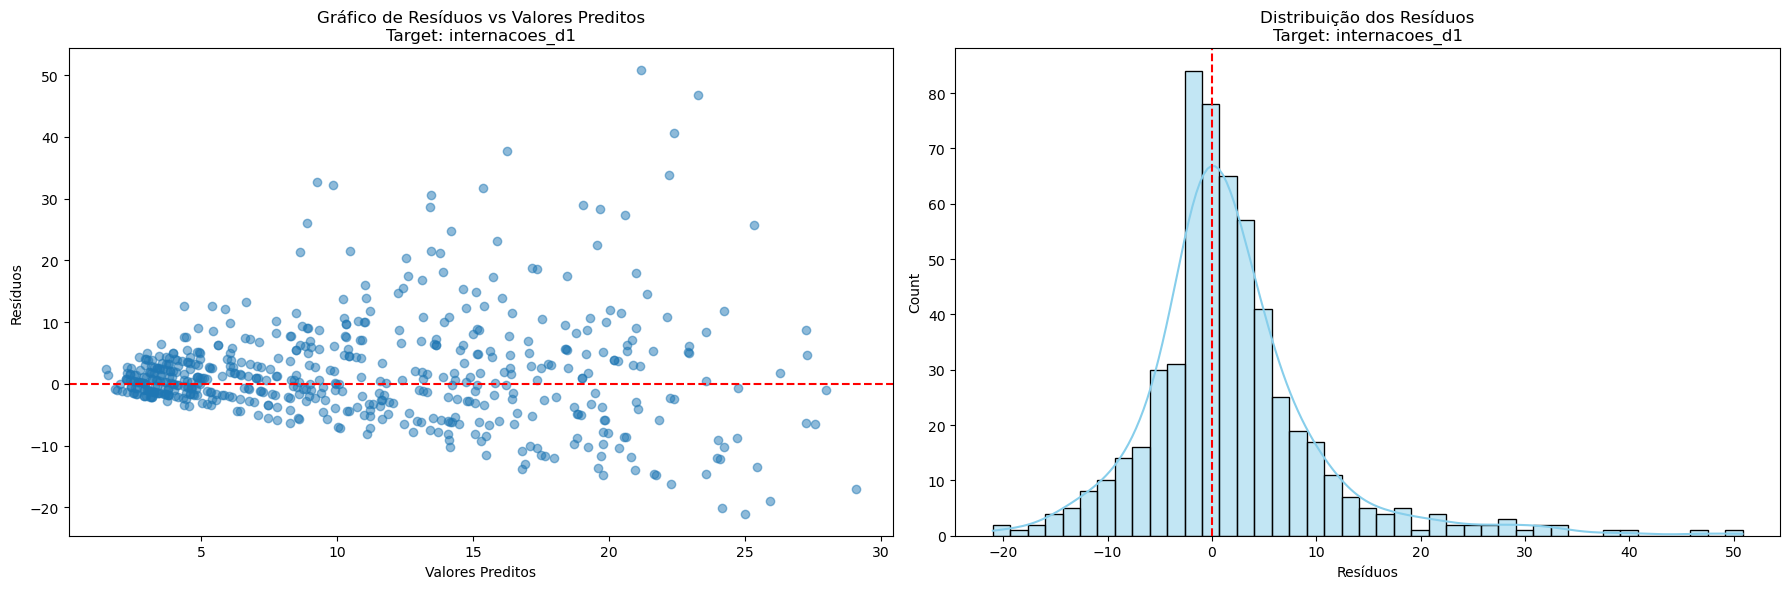

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


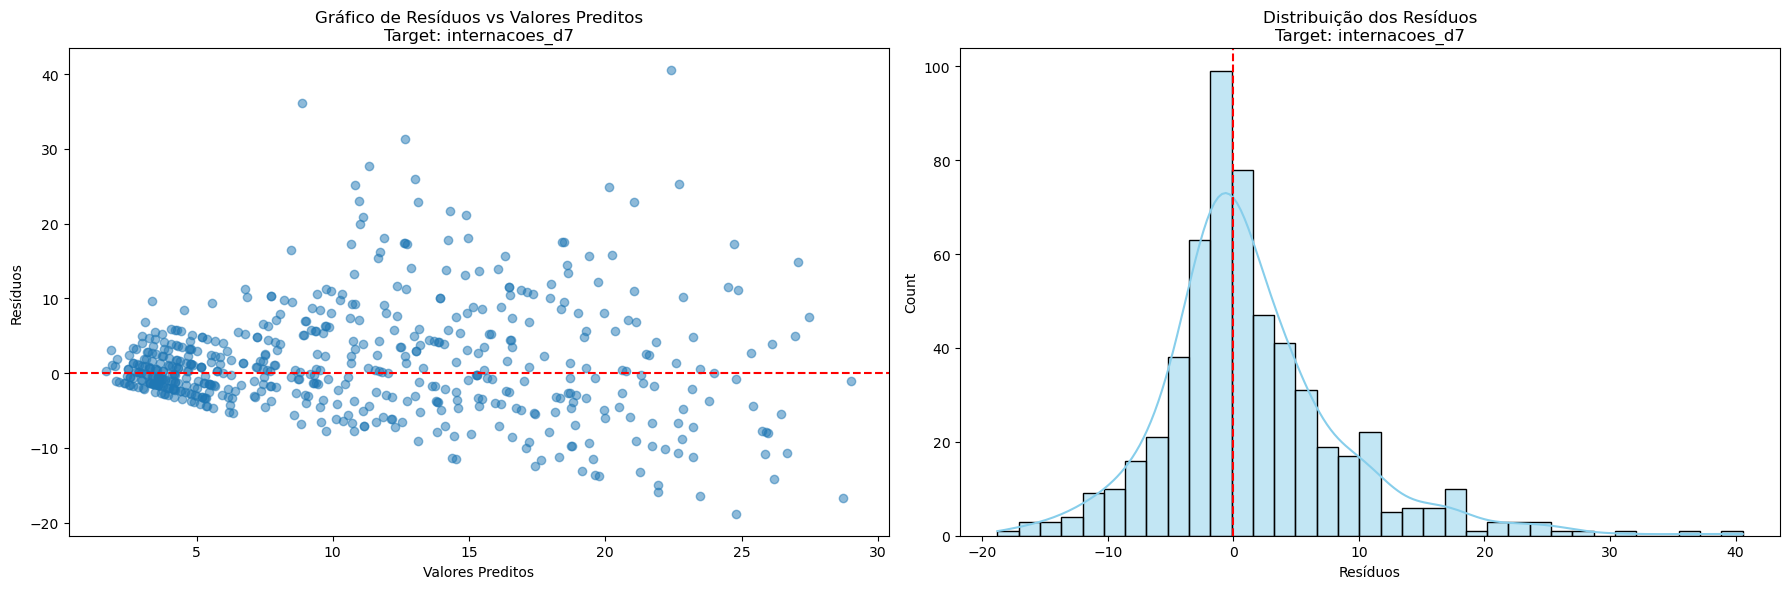

c:\Users\jhter\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


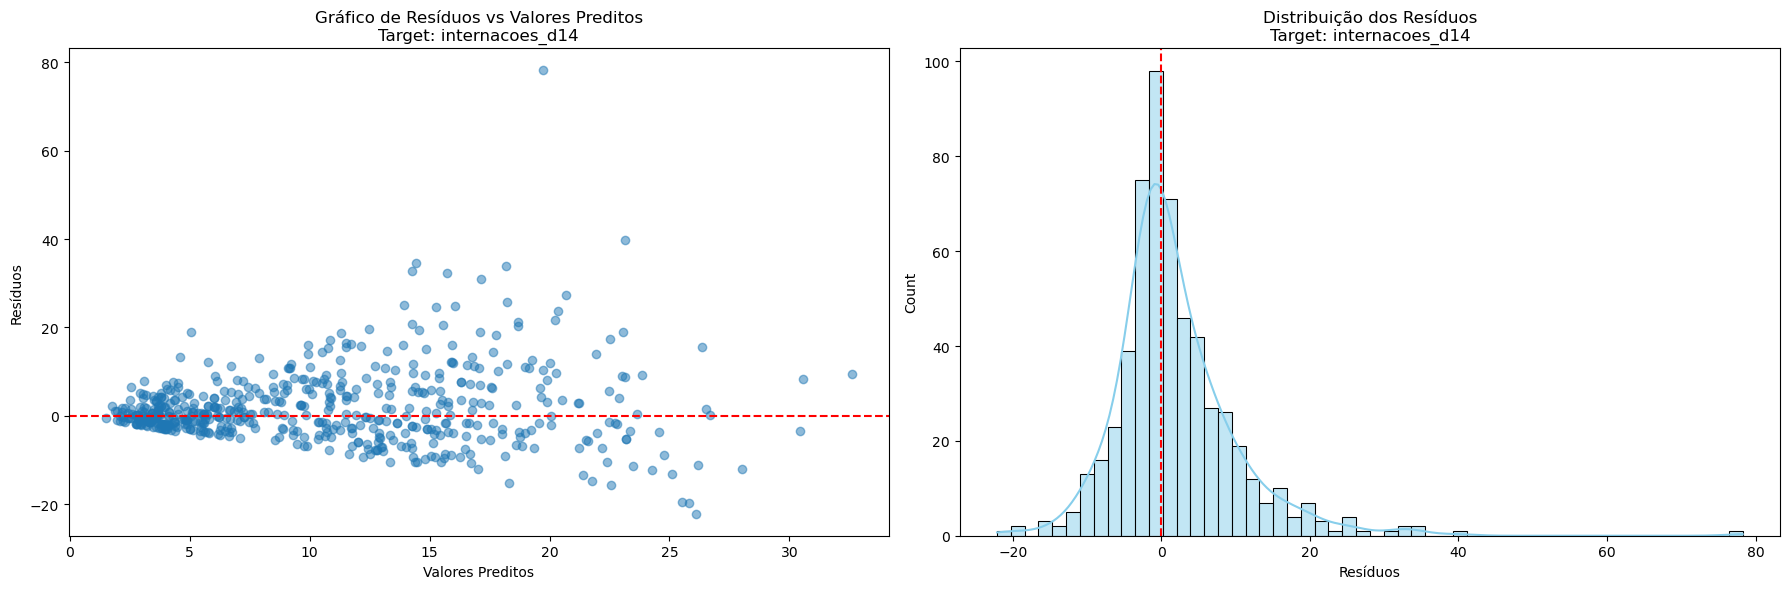

In [24]:
def plot_residuals_side_by_side(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    residuals = y_test - xgb_pred
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(xgb_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title(f'Gráfico de Resíduos vs Valores Preditos\nTarget: {target}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Resíduos')
    plt.title(f'Distribuição dos Resíduos\nTarget: {target}')
    
    plt.tight_layout()
    plt.show()

for alvo in ['internacoes_d1', 'internacoes_d7', 'internacoes_d14']:
    plot_residuals_side_by_side(df, alvo)

#### Análise Temporal das Previsões

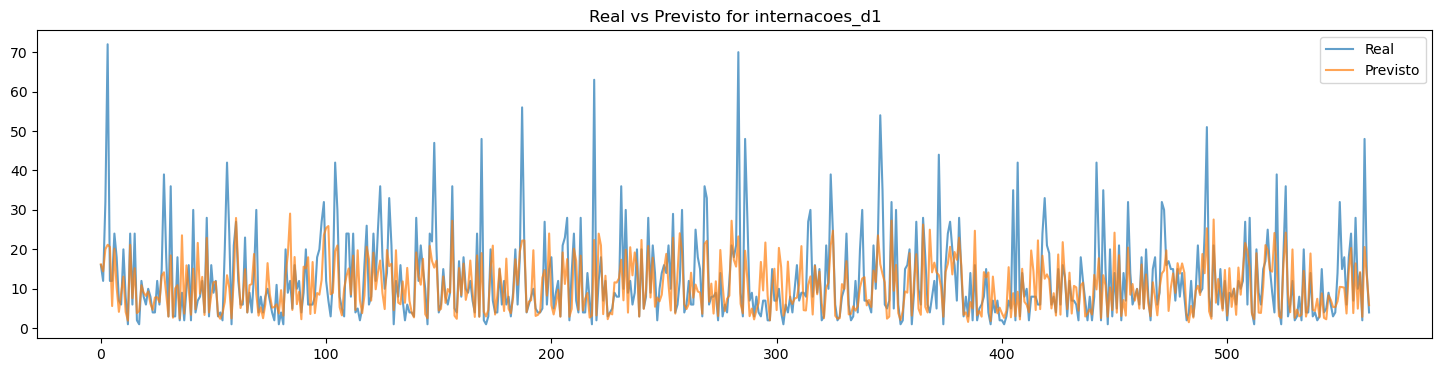

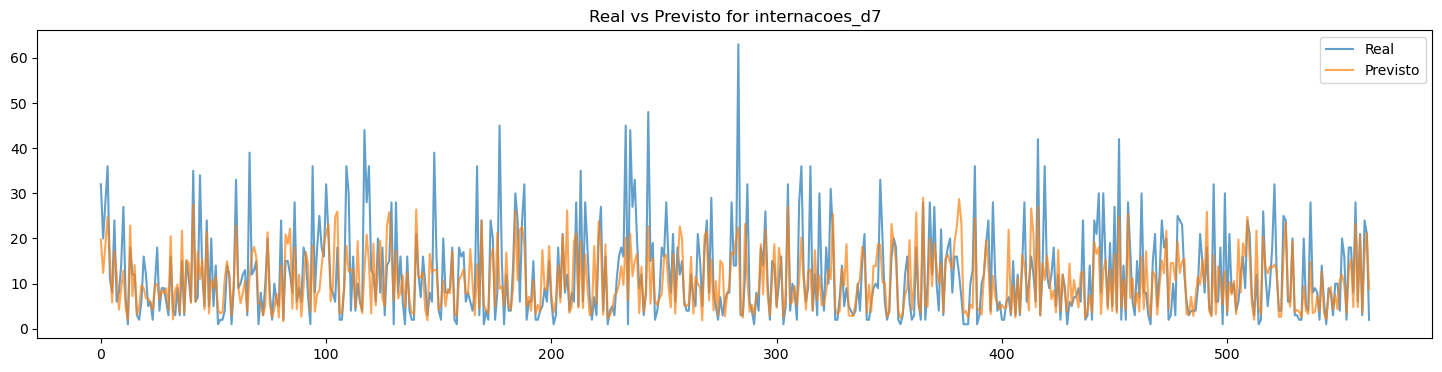

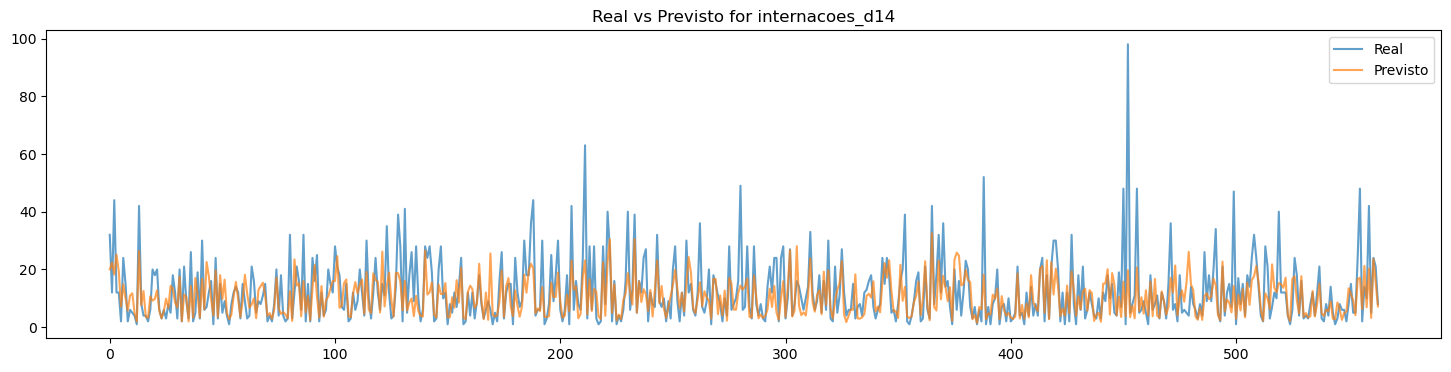

In [25]:
def plot_temporal_predictions(df, target):
    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'internacoes_d1', 'internacoes_d7', 'internacoes_d14', target
    ]]
    
    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)
    
    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Treinar XGBoost
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)
    
    y_test = np.expm1(y_test_log)
    
    # Criar DataFrame para plotagem
    plot_df = pd.DataFrame({
        'Real': y_test,
        'Previsto': xgb_pred
    }).sort_index()
    
    plt.figure(figsize=(18, 4))
    plt.plot(plot_df['Real'], label='Real', alpha=0.7)
    plt.plot(plot_df['Previsto'], label='Previsto', alpha=0.7)
    plt.title(f'Real vs Previsto for {target}')
    plt.legend()
    plt.show()

for alvo in alvos_futuros:
    plot_temporal_predictions(df, alvo)